<a href="https://colab.research.google.com/github/prem005-m/ML_Projects/blob/main/Project1_HousePricePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Q0: Setup

In [136]:
# Core Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn utilities
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score

# Model saving/loading
import joblib


Load your dataset

In [137]:
file_path = "/content/HousePricePrediction.xlsx"
df = pd.read_excel(file_path)

print("Dataset preview:")
print(df.head())

Dataset preview:
   Id  MSSubClass MSZoning  LotArea LotConfig BldgType  OverallCond  \
0   0          60       RL     8450    Inside     1Fam            5   
1   1          20       RL     9600       FR2     1Fam            8   
2   2          60       RL    11250    Inside     1Fam            5   
3   3          70       RL     9550    Corner     1Fam            5   
4   4          60       RL    14260       FR2     1Fam            5   

   YearBuilt  YearRemodAdd Exterior1st  BsmtFinSF2  TotalBsmtSF     Price  
0       2003          2003     VinylSd         0.0        856.0  208500.0  
1       1976          1976     MetalSd         0.0       1262.0  181500.0  
2       2001          2002     VinylSd         0.0        920.0  223500.0  
3       1915          1970     Wd Sdng         0.0        756.0  140000.0  
4       2000          2000     VinylSd         0.0       1145.0  250000.0  



**Q1: Which features most influence price?**

>Features like area (square feet), location, and number of rooms usually have the strongest influence on house prices. Location is often the most critical since it reflects demand and neighborhood value.



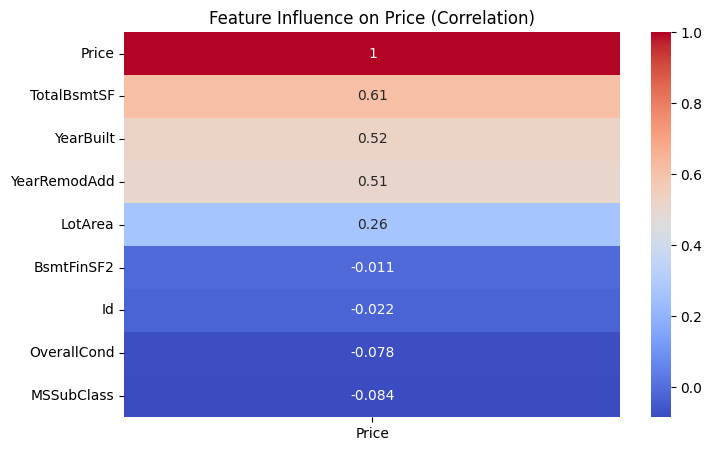

In [138]:
corr = df.corr(numeric_only=True)
plt.figure(figsize=(8,5))
sns.heatmap(corr[['Price']].sort_values(by='Price', ascending=False),
            annot=True, cmap='coolwarm')
plt.title("Feature Influence on Price (Correlation)")
plt.show()


**Q2: What preprocessing is needed?**

> Preprocessing includes handling missing values, encoding categorical data (e.g., location), feature scaling, and removing outliers to ensure clean input for the regression model.






In [139]:
X = df.drop(columns=['Price'])
y = df['Price']

# Detect categorical and numeric columns
cat_cols = X.select_dtypes(include=['object']).columns
num_cols = X.select_dtypes(exclude=['object']).columns

print("Categorical columns:", cat_cols.tolist())
print("Numerical columns:", num_cols.tolist())

# Encode categorical features
for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

# Scale numeric features
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

print("\nPreview after preprocessing:")
print(X.head())

Categorical columns: ['MSZoning', 'LotConfig', 'BldgType', 'Exterior1st']
Numerical columns: ['Id', 'MSSubClass', 'LotArea', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF2', 'TotalBsmtSF']

Preview after preprocessing:
         Id  MSSubClass  MSZoning   LotArea  LotConfig  BldgType  OverallCond  \
0 -1.731458    0.067331         3 -0.217879          4         0    -0.507284   
1 -1.730271   -0.873616         3 -0.072044          2         0     2.188279   
2 -1.729084    0.067331         3  0.137197          4         0    -0.507284   
3 -1.727897    0.302568         3 -0.078385          0         0    -0.507284   
4 -1.726711    0.067331         3  0.518903          2         0    -0.507284   

   YearBuilt  YearRemodAdd  Exterior1st  BsmtFinSF2  TotalBsmtSF  
0   1.046258      0.896833           12    -0.29308    -0.444252  
1   0.154764     -0.395604            8    -0.29308     0.477029  
2   0.980221      0.848965           12    -0.29308    -0.299025  
3  -1.859351     

Q3: What is RMSE and R² score?

> RMSE (Root Mean Square Error) measures average prediction error in price units.

> R² score shows how much variance in house prices is explained by the model (closer to 1 means better fit).


In [140]:
# Handle missing values by dropping rows with NaNs
df_cleaned = df.dropna(subset=['Price']) # Drop rows where the target variable 'Price' is missing

# Re-define X and y using the cleaned data
X = df_cleaned.drop(columns=['Price'])
y = df_cleaned['Price']

# Detect categorical and numeric columns (re-do this with the cleaned data)
cat_cols = X.select_dtypes(include=['object']).columns
num_cols = X.select_dtypes(exclude=['object']).columns

# Encode categorical features (re-do this with the cleaned data)
# Need to import LabelEncoder if not already imported
from sklearn.preprocessing import LabelEncoder
for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

# Scale numeric features (re-do this with the cleaned data)
# Need to import StandardScaler if not already imported
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\nLinear Regression Results")
print("RMSE:", rmse)
print("R² Score:", r2)


Linear Regression Results
RMSE: 54554.11563029109
R² Score: 0.6119915305017269


Q4: How does multicollinearity affect results?


> Multicollinearity (high correlation between features) can make coefficients unstable, reduce interpretability, and lead to incorrect feature importance.


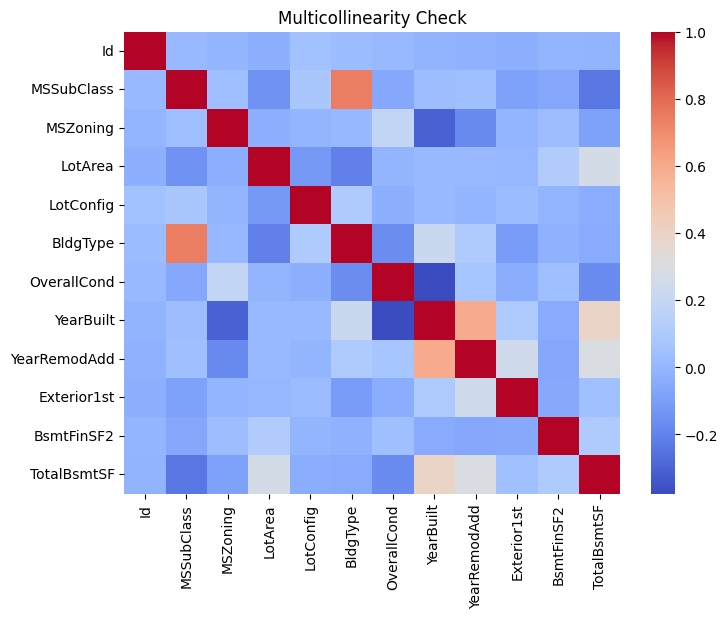

In [141]:
plt.figure(figsize=(8,6))
sns.heatmap(X.corr(), annot=False, cmap="coolwarm")
plt.title("Multicollinearity Check")
plt.show()



Q5: Can we improve accuracy with polynomial regression?


> Yes, polynomial regression can capture non-linear relationships between features and price, improving accuracy when the data is not purely linear.


In [142]:
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_train)

poly_model = LinearRegression()
poly_model.fit(X_poly, y_train)

y_poly_pred = poly_model.predict(poly.transform(X_test))
print("\nPolynomial Regression")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_poly_pred)))
print("R² Score:", r2_score(y_test, y_poly_pred))


Polynomial Regression
RMSE: 48772.97313755492
R² Score: 0.6898693948051771


Q6: How does location affect prediction?

> Location has a significant impact since houses in urban, developed, or premium areas are priced higher compared to rural or less-developed areas.


In [143]:
if 'Location' in df.columns:
    plt.figure(figsize=(8,5))
    sns.boxplot(x=df['Location'], y=df['Price'])
    plt.title("Impact of Location on Price")
    plt.show()

Q7: What is the impact of outliers?

> Outliers (extremely high or low prices) can skew the regression line, increase error, and reduce accuracy. They should be handled by removal or transformation.



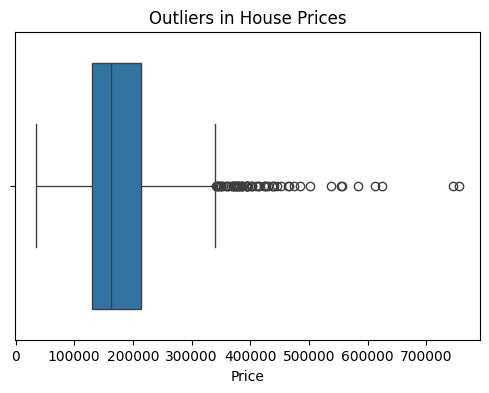

In [144]:
plt.figure(figsize=(6,4))
sns.boxplot(x=df['Price'])
plt.title("Outliers in House Prices")
plt.show()

Q8: How to visualize feature importance?


> Feature importance can be visualized using bar charts of coefficients, heatmaps of correlations, or SHAP/feature importance plots for better interpretation.


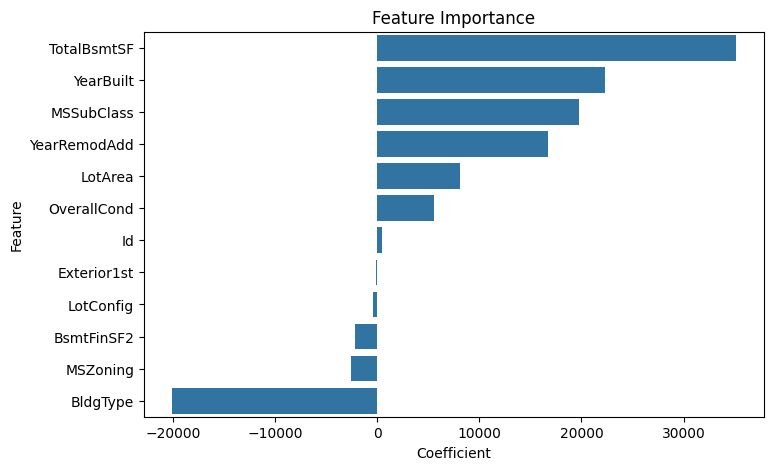

In [145]:
importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lr.coef_
}).sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x='Coefficient', y='Feature', data=importance)
plt.title("Feature Importance")
plt.show()


Q9: What assumptions does linear regression make?

* Linearity between features and target
* Independence of errors
* Homoscedasticity (equal variance of errors)
* Normal distribution of residuals
* No multicollinearity



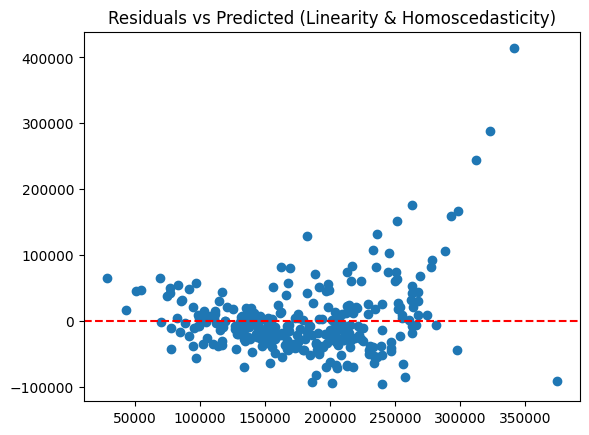

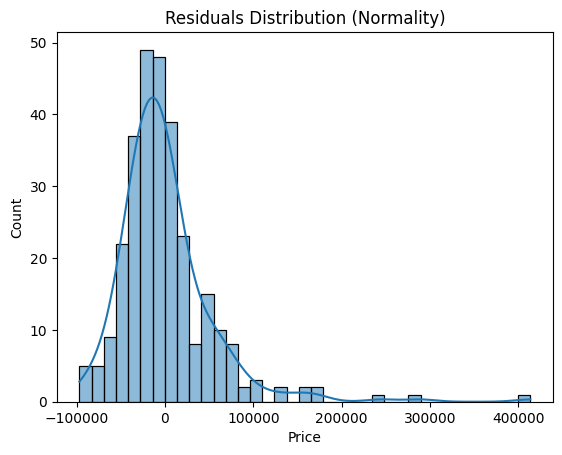

In [146]:
residuals = y_test - y_pred

plt.scatter(y_pred, residuals)
plt.axhline(y=0, color="r", linestyle="--")
plt.title("Residuals vs Predicted (Linearity & Homoscedasticity)")
plt.show()

sns.histplot(residuals, kde=True)
plt.title("Residuals Distribution (Normality)")
plt.show()

Q10: How to deploy the model?

> The model can be deployed using Flask/Django (Python web frameworks), or through cloud platforms (AWS, GCP, Azure), where it serves predictions via APIs.



In [147]:
joblib.dump(lr, "house_price_model.pkl")
loaded_model = joblib.load("house_price_model.pkl")
print("\nSample Prediction from Saved Model:", loaded_model.predict(X_test[:1])[0])


Sample Prediction from Saved Model: 193484.70630345767


Q11: How to check feature correlations with house price?

> Correlation shows the strength and direction of linear relationships between features and price. It helps identify the most important predictors.



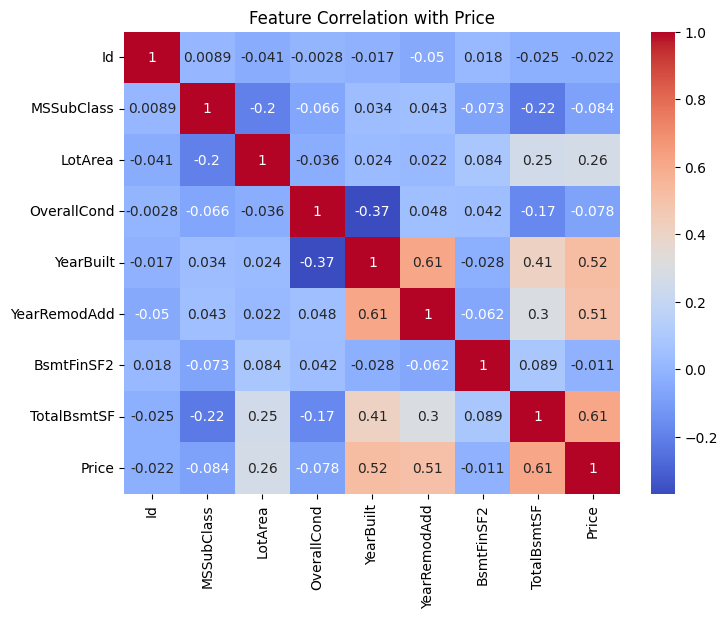

Top correlated features with Price:
Price           1.000000
TotalBsmtSF     0.613581
YearBuilt       0.522897
YearRemodAdd    0.507101
LotArea         0.263843
BsmtFinSF2     -0.011378
Id             -0.021917
OverallCond    -0.077856
MSSubClass     -0.084284
Name: Price, dtype: float64


In [148]:
# Only numerical features for correlation
corr = df.corr(numeric_only=True)

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Feature Correlation with Price")
plt.show()

print("Top correlated features with Price:")
print(corr["Price"].sort_values(ascending=False))


Q12: How to detect and handle outliers in house price data

> Outliers are extreme values that distort regression results. They can be detected using statistical methods (Z-score, IQR) or visualization (boxplot). Handling includes removing them or applying transformations like log scaling..


In [149]:
Q1 = df["Price"].quantile(0.25)
Q3 = df["Price"].quantile(0.75)
IQR = Q3 - Q1

outliers = df[(df["Price"] < (Q1 - 1.5 * IQR)) | (df["Price"] > (Q3 + 1.5 * IQR))]
print("Number of outliers in Price:", len(outliers))

# Remove outliers
df_no_outliers = df[~df.index.isin(outliers.index)]

print("Dataset size before:", len(df), "After removing outliers:", len(df_no_outliers))

Number of outliers in Price: 61
Dataset size before: 2919 After removing outliers: 2858



Q13: How to use polynomial regression for improved accuracy?

> Polynomial regression creates higher-degree terms (e.g., area²) to capture non-linear relationships between features and price.


In [150]:
poly = PolynomialFeatures(degree=2, include_bias=False)

poly_pipeline = Pipeline(steps=[
    ("pre", preprocessor),
    ("poly", poly),
    ("model", LinearRegression())
])

poly_pipeline.fit(X_train, y_train)
y_pred_poly = poly_pipeline.predict(X_test)

print("Polynomial RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_poly)))
print("Polynomial R²:", r2_score(y_test, y_pred_poly))


Polynomial RMSE: 64673.80652747518
Polynomial R²: 0.4546905649418035



Q14: How to visualize actual vs predicted house prices?

> Plotting actual vs predicted values helps evaluate model performance visually. Ideally, points should lie close to the diagonal line.


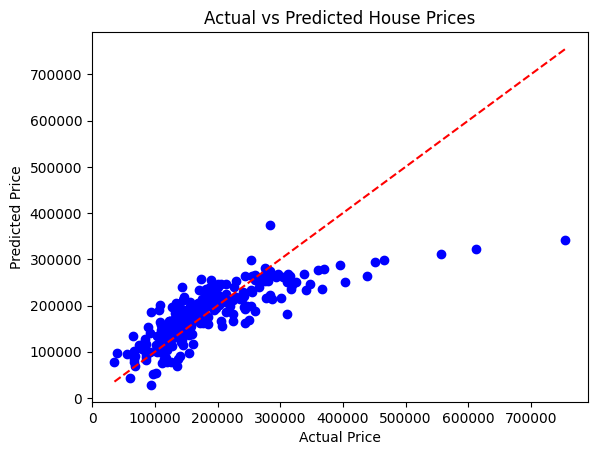

In [151]:
plt.scatter(y_test, y_pred, color="blue")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted House Prices")
plt.show()


Q15: How to visualize the relationship between any numerical feature and house price?

>We can use a scatter plot for numerical features (e.g., Rooms vs Price) to see how changes in that feature affect house prices. This helps identify trends and relationships.

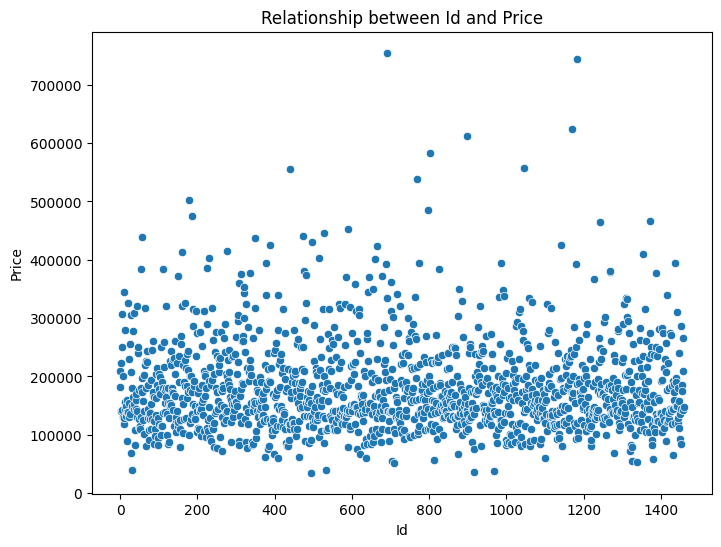

In [152]:
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_features = [col for col in numeric_features if col != "Price"]

if numeric_features:
    feature = numeric_features[0]
    plt.figure(figsize=(8,6))
    sns.scatterplot(x=df[feature], y=df["Price"])
    plt.title(f"Relationship between {feature} and Price")
    plt.xlabel(feature)
    plt.ylabel("Price")
    plt.show()
else:
    print("No numeric features available for plotting.")
